# Sentiment analysis on the Amazon review dataset, using LDA and QDA

We begin by importing the various libraries and functions we will need.

In [1]:
import timeit
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
# Import Bagging
from sklearn.ensemble import BaggingClassifier
# Import LDA and QDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

Note that we are importing a previously processed csv file.

In [2]:
# Importing data start timer
print('Importing data')
start = timeit.default_timer()

data_train = pd.read_csv('data/amazon_clean_train.csv', encoding='utf-8')
data_test = pd.read_csv('data/amazon_clean_test.csv', encoding='utf-8')

# Importing data stop timer
stop = timeit.default_timer()
print('Time: ', stop - start)

data_train.Label.value_counts()
data_test.Label.value_counts()

Importing data
Time:  15.822713599998679


1    200000
0    200000
Name: Label, dtype: int64

We now need to vectorize our data. Here we need to explain some aspects of what we are doing. 

The TfidfVectorizer was used both to prepare the strings, but also to strip away some useless data (that caused clutter in the dataset). The exact values were found through a bit of trial and error.

The reason we use apply(lambda x: np.str_(x)) is that we had occasional problems where, in spite of our efforts, we found that sometimes a line in the dataset was not recognised as a string. We found that the apply lambda function was a quick and easy way to get around this problem.

In [3]:
#tf_idf_cv = TfidfVectorizer()
tf_idf_cv = TfidfVectorizer(min_df = 25, max_df = 0.8,
                    max_features = None, sublinear_tf = True, use_idf = True)


# Fitting vectors start timer
print('Fitting vectors')
start = timeit.default_timer()
trainX = tf_idf_cv.fit_transform(data_train['Review']
                                 .apply(lambda x: np.str_(x)))
testX = tf_idf_cv.transform(data_test['Review']
                            .apply(lambda x: np.str_(x)))
testY = data_test['Label'].values.astype(int)
trainY = data_train['Label'].values.astype(int)
# Fitting vectors stop timer
stop = timeit.default_timer()
print('Time: ', stop - start)

Fitting vectors
Time:  186.19767109999884


## Dimensional reduction

We have one problem with using scipy's LDA and QDA, which is that both these systems require dense matrices. However our fit was made using TfidfVectorizer which outputs a sparse matrix (as does CountVectorizer). Further if we try to expand this matrix into a dense one we end up requiring over a TiB of memory.

Simply picking a limited number of max_features for TfidfVectorizer is also unsatisfactory, since we do not know how good they'd be at predicting.

Therefore we need to reduce the dimensions (dimension reduction by way of PCA, or just referred to as PCA below). We pick 200 as the proper number of dimensions because this would require a substantial, but surmountable, amount of RAM. Further we pick n_iter=7 and random_state=42 because that is what was on the code snippet at the webpage documenting this function.

Because we use a sparse matrix we are unable to use normal SVD and instead use a function called TruncatedSVD which can handle sparsematrices and returns a dense matrix.

In [4]:
# Conducting Dimension reduction
print('Creating SVD')
start = timeit.default_timer()
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=200, n_iter=7, random_state=42)
svd.fit(trainX, trainY)
stop = timeit.default_timer()
print('Time: ', stop - start)

print('PCA on training set')
start = timeit.default_timer()
trainXpca = svd.transform(trainX)
stop = timeit.default_timer()
print('Time: ', stop - start)

print('PCA on test set')
start = timeit.default_timer()
testXpca = svd.transform(testX)
stop = timeit.default_timer()
print('Time: ', stop - start)

Creating SVD
Time:  1252.7121988
PCA on training set
Time:  20.12553939999998
PCA on test set
Time:  3.3134262999992643


 ## LDA and QDA Theory


LDA and QDA models the distribution of the predictors X (independent variables) separately in each of the response classes (i.e. default = “Yes”, default = “No” ), and then uses Bayes’ theorem to flip these around into estimates for the probability of the response category given the value of X.
They consider the following assumptions:
- 	Predictor variables X are drawn from a multivariate Gaussian distribution.
- 	LDA assumes equality of covariances among the predictor variables X across each all levels of Y while QDA model does not.
- 	LDA and QDA require the number of predictor variables (p) to be less than the sample size (n). 


### Linear Discriminant Analysis (LDA)

LDA calculates an “estimated discriminant score” by finding linear combinations of the independent variables.LDA classifier is calculated, for a single predictor variable x as:


$
\delta _{k}(x)=x\frac{\mu_{k}}{\sigma ^{2}} - \frac{\mu _{k}^{2}}{2\sigma ^{2}} + log(\pi _{k})
$

where:
- $\delta _{k}(x) $ is the estimated discriminant score
- $\mu _{k} $ is the average of all the training observations from the kth class
- $ \sigma ^{2}$  is the weighted average of the sample variances for each of the K classes
- $\mu _{k} $ is the prior probability that an observation belongs to the kth class 


LDA classifier score differs when dealing with more than one predictor variable. In this case the observations in the kth class are drawn from a multivariate Gaussian distribution N( $\mu_{k}$,$\Sigma$). The estimated discriminant score is:

$
\delta _{k}(x)=x^{T}\Sigma  ^{-1}\mu_{k} - \frac{1}{2}\mu_{k}^{T}\Sigma  ^{-1} - \mu_{k} + log(\pi _{k})
$

where $\mu _{k} $ is a class-specific mean vector, and $\Sigma$ is a covariance matrix that is common to all K classes.

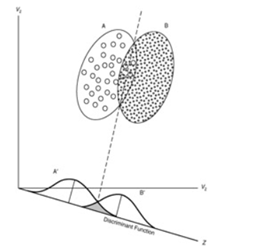

Fig. 1: normal distribution in LDA

### Quadratic Discriminant Analysis (QDA)
QDA classifier assumes normal distribution of predictors(X) from each Y class, but each one with its own covariance matrix. It can be expressed that a predictor X is of the form X∼N( $\mu_{k}$,$\Sigma_{k}$), where $\Sigma_{k}$ is a covariance matrix for the kth class. 
The estimated discriminant score is:


$\delta _{k}(x)=- \frac{1}{2}x^{T}\Sigma_{k}  ^{-1} x + x^{T}\Sigma_{k} ^{-1}\mu_{k} - \frac{1}{2}\mu_{k}^{T}\Sigma_{k} ^{-1}\mu_{k}  - \frac{1}{2} log(\left | \Sigma_{k} \right |) + log(\pi _{k})$

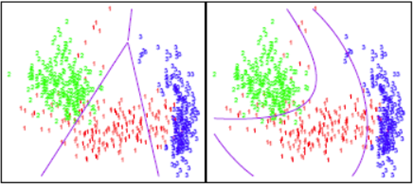

Fig. 2: Left side LDA, right side QDA. It is clear that QDA capture the different covariances and is more acurate

# LDA and QDA analysis
## LDA
Creating an LDA, fairly straight forward testing accuracy is there is a linear hyperplane seperating the two areas. This is like QDA except it assumes that each class shares the same covariance matrix.

In [5]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

In [6]:
## Linear Discriminant Analysis
# LDA start timer
print('Linear Discriminant Analysis')
start = timeit.default_timer()

# Set LDA
lda_class = LinearDiscriminantAnalysis()
lda_class.fit(trainXpca, trainY)
stop = timeit.default_timer()
print('Training time: ', stop - start)
start = timeit.default_timer()
# Make prediction
y_pred = lda_class.predict(testXpca)
# MNB stop timer
stop = timeit.default_timer()
print('Test time: ', stop - start)
#Performance Measures
accuracy_lda = 100*accuracy_score(testY,y_pred)
precision_lda = 100*precision_score(testY,y_pred)
f1_lda = 100*f1_score(testY,y_pred)
# Printing results
print("Out of", len(testY), 'datapoints')
print("Accuracy: {:.04f}%".format(accuracy_lda))
print("Precision: {:.04f}%".format(precision_lda))
print("F1 score: {:.04f}%".format(f1_lda))
m = confusion_matrix(y_true=testY, y_pred=y_pred)
print("Confusion Matrix: \n",m)

Linear Discriminant Analysis
Training time:  238.2439044999992
Test time:  3.3493267000012565
Out of 400000 datapoints
Accuracy: 84.6310%
Precision: 84.7753%
F1 score: 84.5990%
Confusion Matrix: 
 [[169677  30323]
 [ 31153 168847]]


In [9]:
y_perf_lda = np.array(["Accuracy","Precision","F1"])
ypos = np.arange(len(y_perf_lda))
y_val_lda = np.array([accuracy_lda,precision_lda,f1_lda])

<BarContainer object of 3 artists>

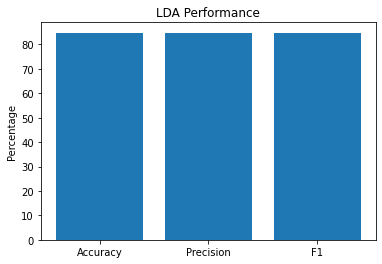

In [10]:
plt.xticks(ypos,y_perf_lda)
plt.ylabel("Percentage")
plt.title("LDA Performance")
plt.bar(ypos,y_val_lda)

## QDA
The QDA assumes that the two classes do not necessarily share the same covariance matrix. Note that this method easily becomes very similar to Naive Bayesian, so we would expect similar results.

In [7]:
## Quadratic Discriminant Analysis
# QDA start timer
print('Quadratic Discriminant Analysis')
start = timeit.default_timer()

# Set QDA
qda_class = QuadraticDiscriminantAnalysis()
qda_class.fit(trainXpca, trainY)
stop = timeit.default_timer()
print('Training time: ', stop - start)
start = timeit.default_timer()
# Make prediction
y_pred = qda_class.predict(testXpca)
# MNB stop timer
stop = timeit.default_timer()
print('Test time: ', stop - start)
#Performance Measures
accuracy_qda = 100*accuracy_score(testY,y_pred)
precision_qda = 100*precision_score(testY,y_pred)
f1_qda = 100*f1_score(testY,y_pred)
# Printing results
print("Out of", len(testY), 'datapoints')
print("Accuracy: {:.04f}%".format(accuracy_qda))
print("Precision: {:.04f}%".format(precision_qda))
print("F1 score: {:.04f}%".format(f1_qda))
m = confusion_matrix(y_true=testY, y_pred=y_pred)
print("Confusion Matrix: \n",m)

Quadratic Discriminant Analysis
Training time:  123.93757840000035
Test time:  6.000218300003326
Out of 400000 datapoints
Accuracy: 80.4990%
Precision: 80.0945%
F1 score: 80.6292%
Confusion Matrix: 
 [[159654  40346]
 [ 37658 162342]]


As we can see this acually led to a worse result.

In [11]:
y_perf_qda = np.array(["Accuracy","Precision","F1"])
ypos = np.arange(len(y_perf_qda))
y_val_qda = np.array([accuracy_qda,precision_qda,f1_qda])

<BarContainer object of 3 artists>

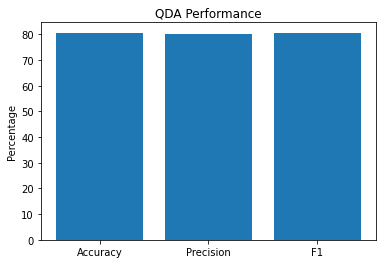

In [12]:
plt.xticks(ypos,y_perf_qda)
plt.ylabel("Percentage")
plt.title("QDA Performance")
plt.bar(ypos,y_val_qda)

In [29]:
y_accu_bayesian = np.array(["MultiBayes","Bagging"])
y_f1_bayesian = np.array(["MultiBayes","Bagging"])
ypos = np.arange(len(y_accu_bayesian))
y_val_accubay = np.array([accuracy_mb,accuracy_bmb])
y_val_f1bay = np.array([f1_mb,f1_bmb])

<BarContainer object of 2 artists>

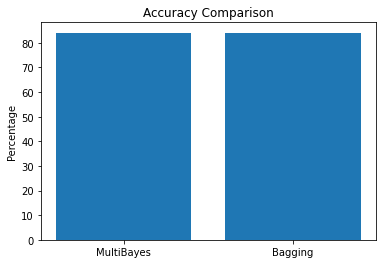

In [30]:
plt.xticks(ypos,y_accu_bayesian)
plt.ylabel("Percentage")
plt.title("Accuracy Comparison")
plt.bar(ypos,y_val_accubay)

<BarContainer object of 2 artists>

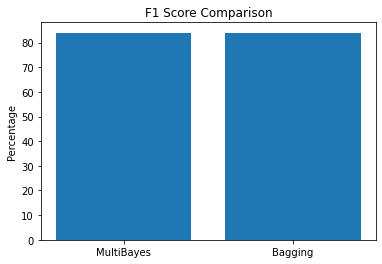

In [31]:
plt.xticks(ypos,y_f1_bayesian)
plt.ylabel("Percentage")
plt.title("F1 Score Comparison")
plt.bar(ypos,y_val_f1bay)

Somewhat surprisingly perhaps we see that the LDA does much better than the QDA, now of course there is a chance that the QDA could be overfitted. Therefore we will use bagging on both the QDA and LDA.

# Bagging QDA and LDA

We will be using 620K samples as our baseline, as this is the sampling rate we've mostly used elsewhere and we want consistent results. Also in other samples this has proven to be something of a sweet spot.

## Bagging LDA

In [13]:
## Bagging Linear Discriminant Analysis
# Bagging LDA start timer
print('Bagging LDA')
start = timeit.default_timer()

LDA_bag = BaggingClassifier(base_estimator=
                LinearDiscriminantAnalysis(), n_jobs=3, verbose=0,
                n_estimators=12, random_state=0, max_samples=(620*(10**3)),
                ).fit(trainXpca, trainY)
# stop timer
stop = timeit.default_timer()
print('Training time: ', stop - start)
# Start timer
start = timeit.default_timer()
y_pred = LDA_bag.predict(testXpca)
# stop timer
stop = timeit.default_timer()
print('Test time: ', stop - start)
#Performance Measures
accuracy_ldabag = 100*accuracy_score(testY,y_pred)
precision_ldabag = 100*precision_score(testY,y_pred)
f1_ldabag = 100*f1_score(testY,y_pred)
# Printing results
print("Out of", len(testY), 'datapoints')
print("Accuracy: {:.04f}%".format(accuracy_ldabag))
print("Precision: {:.04f}%".format(precision_ldabag))
print("F1 score: {:.04f}%".format(f1_ldabag))
m = confusion_matrix(y_true=testY, y_pred=y_pred)
print("Confusion Matrix: \n",m)

Bagging LDA
Training time:  310.7673794000002
Test time:  15.681182199998148
Out of 400000 datapoints
Accuracy: 84.6290%
Precision: 84.7593%
F1 score: 84.6001%
Confusion Matrix: 
 [[169633  30367]
 [ 31117 168883]]


In [15]:
y_perf_ldabag = np.array(["Accuracy","Precision","F1"])
ypos = np.arange(len(y_perf_ldabag))
y_val_ldabag = np.array([accuracy_ldabag,precision_ldabag,f1_ldabag])

<BarContainer object of 3 artists>

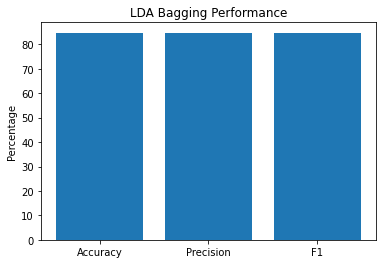

In [16]:
plt.xticks(ypos,y_perf_ldabag)
plt.ylabel("Percentage")
plt.title("LDA Bagging Performance")
plt.bar(ypos,y_val_ldabag)

## Bagging QDA

In [17]:
## Bagging Quadratic Discriminant Analysis
# Bagging QDA start timer
print('Bagging QDA')
start = timeit.default_timer()

QDA_bag = BaggingClassifier(base_estimator=
                QuadraticDiscriminantAnalysis(), n_jobs=3, verbose=0,
                n_estimators=12, random_state=0, max_samples=(620*(10**3)),
                ).fit(trainXpca, trainY)
# stop timer
stop = timeit.default_timer()
print('Training time: ', stop - start)
# Start timer
start = timeit.default_timer()
y_pred = QDA_bag.predict(testXpca)
# stop timer
stop = timeit.default_timer()
print('Test time: ', stop - start)
#Performance Measures
accuracy_qdabag = 100*accuracy_score(testY,y_pred)
precision_qdabag = 100*precision_score(testY,y_pred)
f1_qdabag = 100*f1_score(testY,y_pred)
# Printing results
print("Out of", len(testY), 'datapoints')
print("Accuracy: {:.04f}%".format(accuracy_qdabag))
print("Precision: {:.04f}%".format(precision_qdabag))
print("F1 score: {:.04f}%".format(f1_qdabag))
m = confusion_matrix(y_true=testY, y_pred=y_pred)
print("Confusion Matrix: \n",m)

Bagging QDA
Training time:  203.51115579999896
Test time:  33.86582710000221
Out of 400000 datapoints
Accuracy: 80.4900%
Precision: 80.0779%
F1 score: 80.6227%
Confusion Matrix: 
 [[159610  40390]
 [ 37650 162350]]


And it is clear that bagging does not have a noticable effect, except maybe for the LDA. However, even here it does not come near to the level offered by LinearSVC.

As we can see this acually led to a worse result.

In [18]:
y_perf_qdabag = np.array(["Accuracy","Precision","F1"])
ypos = np.arange(len(y_perf_qdabag))
y_val_qdabag = np.array([accuracy_qdabag,precision_qdabag,f1_qdabag])

<BarContainer object of 3 artists>

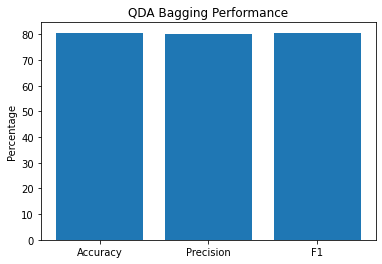

In [19]:
plt.xticks(ypos,y_perf_qdabag)
plt.ylabel("Percentage")
plt.title("QDA Bagging Performance")
plt.bar(ypos,y_val_qdabag)

In [23]:
y_accu_ql = np.array(["LDA","LDA","LDA Bagging","QDA Bagging"])
y_f1_ql = np.array(["LDA","LDA","LDA Bagging","QDA Bagging"])
ypos = np.arange(len(y_accu_ql))
y_val_accuql = np.array([accuracy_lda,accuracy_qda,accuracy_ldabag,accuracy_qdabag])
y_val_f1ql = np.array([f1_lda,f1_qda,f1_ldabag,f1_qdabag])

<BarContainer object of 4 artists>

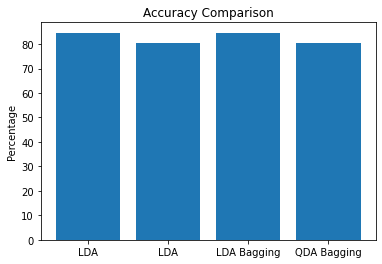

In [24]:
plt.xticks(ypos,y_accu_ql)
plt.ylabel("Percentage")
plt.title("Accuracy Comparison")
plt.bar(ypos,y_val_accuql)

<BarContainer object of 4 artists>

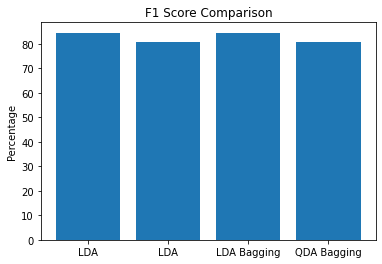

In [25]:
plt.xticks(ypos,y_f1_ql)
plt.ylabel("Percentage")
plt.title("F1 Score Comparison")
plt.bar(ypos,y_val_f1ql)

 ## References:
https://uc-r.github.io/discriminant_analysis